# Out of fold evaluation for EfficientDet

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernels for this competition:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)
- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)
- [[Inference] EfficientDet](https://www.kaggle.com/shonenkov/inference-efficientdet)

# Main Idea

People from ODS slack asked me about competition metrics on my validation split for effdet. So I have decided to publish notebook with calculation oof-score for my models and selection best threshold :) 

For this aims I have trained 5-folds using published [training kernel](https://www.kaggle.com/shonenkov/training-efficientdet). 

It is very simple notebook without any really good idea, but I hope It can help you evaluate effdet models in the future during research!
So, lets start! 

[Update]:

I would like to share with you mixup approach with 3 different implementation, also here do evaluation for new models.

Mixup is very simple approach, you can see this picture and understand main idea:

![](https://cdn-images-1.medium.com/max/1000/0*yLCQYAtNAh28LQks.png)

Lets do this simple approach for wheat detection!

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

from ensemble_boxes import *
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm import tqdm
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from sklearn.model_selection import StratifiedKFold

# Prepare folds

In [3]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [5]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [6]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

def collate_fn(batch):
    return tuple(zip(*batch))


class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
#                     target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

In [7]:
def draw_image_and_boxes(list_images, list_boxes):
    fig, ax = plt.subplots(4, 2, figsize=(16, 32))
    for i, (image, boxes) in enumerate(zip(list_images, list_boxes)):
        for box in boxes:
            cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 1, 0), 2)
        ax.set_axis_off()
        ax.imshow(image);

In [8]:
dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == 0].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

# Mixup #1

full images 1:1

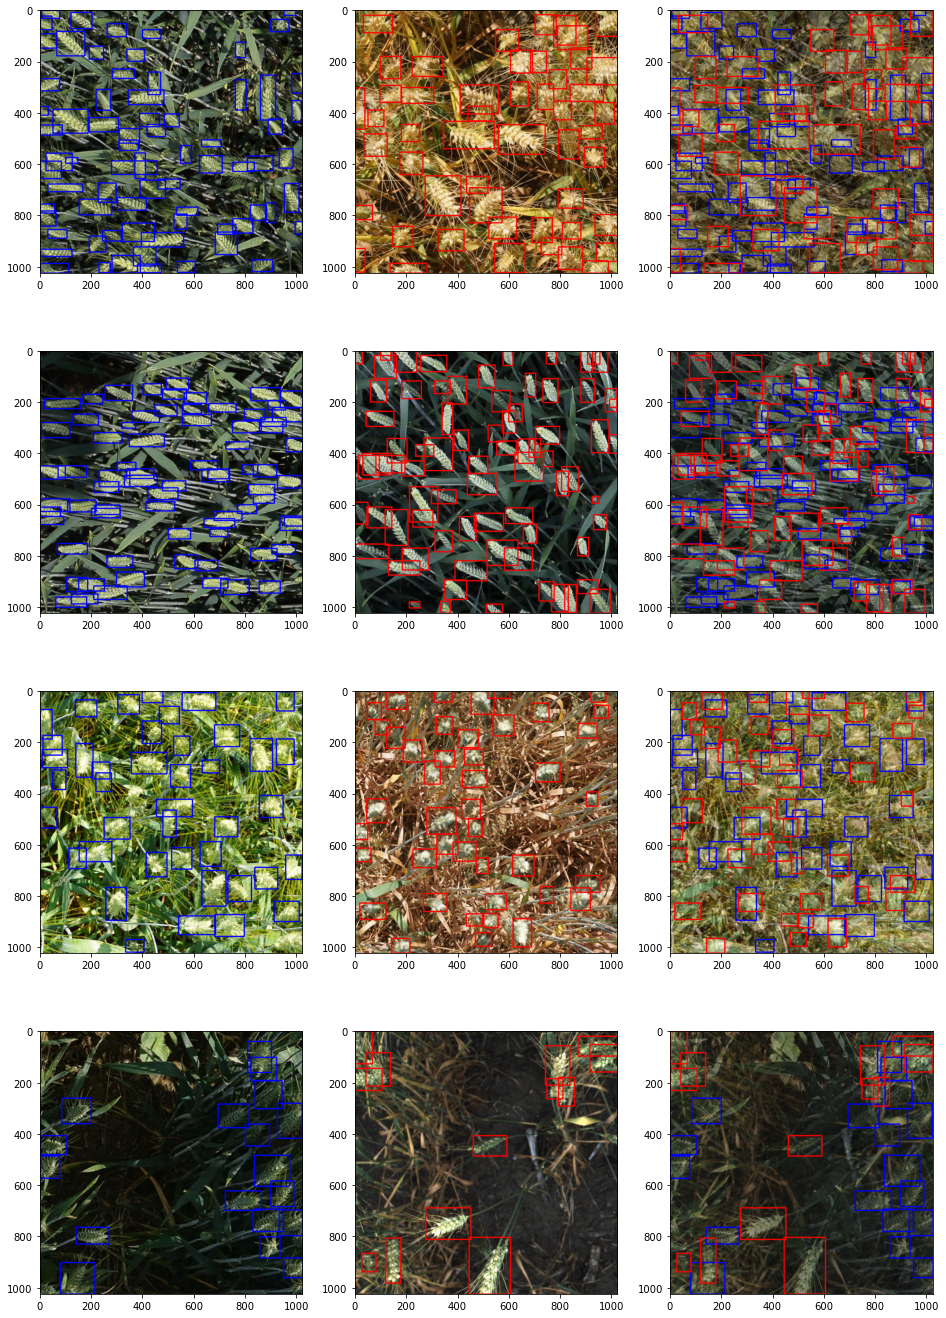

In [9]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

# Mixup #2

random selection

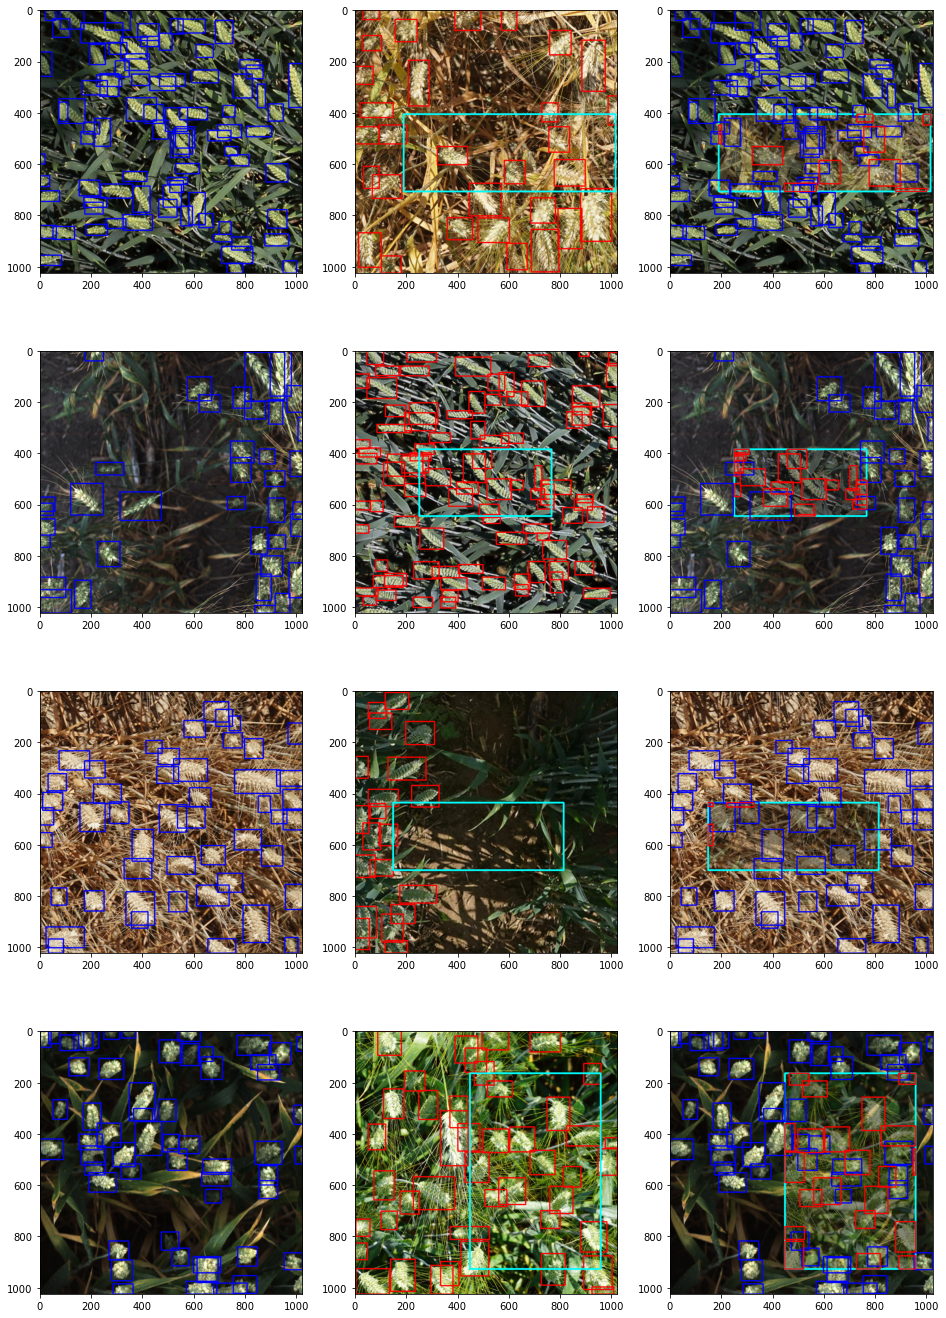

In [10]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
    
    mixup_image = image.copy()

    imsize = image.shape[0]
    x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
    x2, y2 = [int(random.uniform(imsize * 0.55, imsize * 1.0)) for _ in range(2)]
    
    mixup_boxes = r_boxes.copy()
    mixup_boxes[:, [0, 2]] = mixup_boxes[:, [0, 2]].clip(min=x1, max=x2)
    mixup_boxes[:, [1, 3]] = mixup_boxes[:, [1, 3]].clip(min=y1, max=y2)
    
    mixup_boxes = mixup_boxes.astype(np.int32)
    mixup_boxes = mixup_boxes[np.where((mixup_boxes[:,2]-mixup_boxes[:,0])*(mixup_boxes[:,3]-mixup_boxes[:,1]) > 0)]
    
    cv2.rectangle(r_image,(x1, y1),(x2,  y2),(0, 1, 1), 5)
    
    mixup_image[y1:y2, x1:x2] = (mixup_image[y1:y2, x1:x2] + r_image[y1:y2, x1:x2])/2
    
    cv2.rectangle(mixup_image,(x1, y1),(x2,  y2),(0, 1, 1), 5)
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in mixup_boxes.astype(int):
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

# Mixup #3

using only for one part of [mosaic](https://www.kaggle.com/nvnnghia/awesome-augmentation), getting fix size 2 random boxes from image1 and image2, then mixing

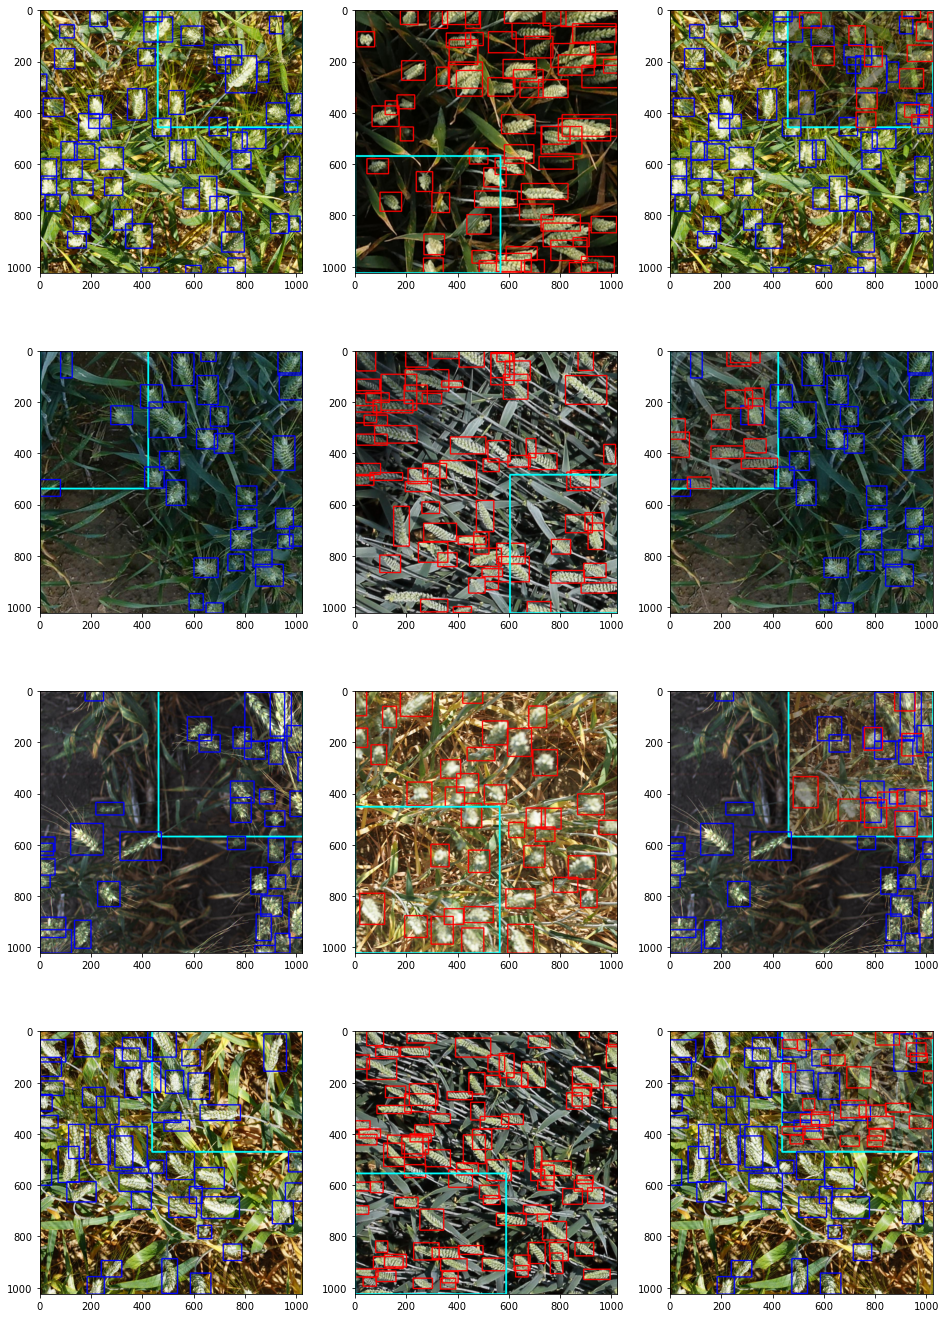

In [11]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = dataset.load_image_and_boxes(random.randint(0, dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

    imsize = image.shape[0]
    w,h = imsize, imsize
    s = imsize // 2

    xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
    direct = random.randint(0, 3)

    result_image = image.copy()
    result_boxes = []

    if direct == 0:
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif direct == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif direct == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif direct == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    padw = x1a - x1b
    padh = y1a - y1b

    r_boxes[:, 0] += padw
    r_boxes[:, 1] += padh
    r_boxes[:, 2] += padw
    r_boxes[:, 3] += padh

    result_boxes.append(r_boxes)

    result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 
    
    cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
    cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    
    result_boxes = np.concatenate(result_boxes, 0)
    np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
    result_boxes = result_boxes.astype(np.int32)
    result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in result_boxes.astype(int):
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(result_image)

At the moment I have used only Mixup\#1, things that I have changed in [baseline](https://www.kaggle.com/shonenkov/training-efficientdet) for getting new score:

- add mixup\#1
- equal proba mixup/cutmix
- epoch 40 --> 100
- patience 1 --> 2

After this I have got new best score:

- OOF-score 0.6859 --> 0.6906
- LB score 0.7294 --> 0.7318

Lets do oof-evaluation.

# Load Models

In [12]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

models = [
    load_net('../input/effdet5-folds-mixup/fold0-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold1-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold2-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold3-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold4-best-v2.bin'),
]

# Out of fold prediction:

In [13]:
%%time

all_predictions = []
for fold_number in range(5):
    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

    for images, targets, image_ids in tqdm(validation_loader, total=len(validation_loader)):
        with torch.no_grad():
            images = torch.stack(images)
            images = images.cuda().float()
            det = models[fold_number](images, torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                all_predictions.append({
                    'pred_boxes': (boxes*2).clip(min=0, max=1023).astype(int),
                    'scores': scores,
                    'gt_boxes': (targets[i]['boxes'].cpu().numpy()*2).clip(min=0, max=1023).astype(int),
                    'image_id': image_ids[i],
                })

100%|██████████| 169/169 [00:41<00:00,  4.12it/s]

CPU times: user 2min 23s, sys: 6.25 s, total: 2min 29s
Wall time: 3min 31s


# Evaluation

Here I have used [really good evaluation scripts](https://www.kaggle.com/pestipeti/competition-metric-details-script) by [Peter](https://www.kaggle.com/pestipeti), I recommend to use it! 

In [14]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")
    
# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [15]:
def calculate_final_score(all_predictions, score_threshold):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
        final_scores.append(image_precision)

    return np.mean(final_scores)

# Search best threshold for best score:

In [16]:
%%time

best_final_score, best_score_threshold = 0, 0
for score_threshold in tqdm(np.arange(0, 1, 0.01), total=np.arange(0, 1, 0.01).shape[0]):
    final_score = calculate_final_score(all_predictions, score_threshold)
    if final_score > best_final_score:
        best_final_score = final_score
        best_score_threshold = score_threshold

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]

CPU times: user 1min 7s, sys: 422 ms, total: 1min 7s
Wall time: 1min 7s


In [17]:
print('-'*30)
print(f'[Best Score Threshold]: {best_score_threshold}')
print(f'[OOF Score]: {best_final_score:.4f}')
print('-'*30)

------------------------------
[Best Score Threshold]: 0.37
[OOF Score]: 0.6906
------------------------------


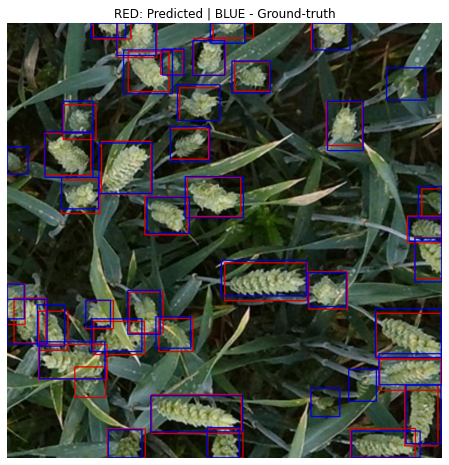

In [18]:
i = 0

gt_boxes = all_predictions[i]['gt_boxes'].copy()
pred_boxes = all_predictions[i]['pred_boxes'].copy()
scores = all_predictions[i]['scores'].copy()
image_id = all_predictions[i]['image_id']

indexes = np.where(scores>best_score_threshold)
pred_boxes = pred_boxes[indexes]
scores = scores[indexes]

show_result(image_id, pred_boxes, gt_boxes)

I understand that you need time for running your own models, so I don't share dataset of models with folds. But if you need their for your own experiments - write it in comments!

# Inference

In [19]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class TestDatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
    )

dataset = TestDatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    for net in models:
        with torch.no_grad():
            det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
            result = []
            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                result.append({
                    'boxes': boxes[indexes],
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.45, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels


def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)


results = []

for images, image_ids in data_loader:
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)
        
        
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)

### Thank you for reading my kernel!